# Experiment Workbench

In [1]:
import os, sys, math, datetime
import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,DepthwiseConv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
 
# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths
from workbench.utils.utils import parse_model_name

#from dotenv import load_dotenv
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
#import deeplake


In [2]:
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

# Confirm that TensorFlow can access GPU
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.10.0
Found GPU at: /device:GPU:0


In [3]:
# TODO:

# Add learning rate schedule

# tf.compat.v1.disable_eager_execution()

In [4]:
# DANGER ZONE: Disable warning messages

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [5]:


# set the random seeds
os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
random.seed(hash("setting_random seeds") % 2**32 -1)
np.random.seed(hash("improves reproducibility") % 2**32 -1)
tf.random.set_seed(hash("by removing stochasticity") %2 *32 -1 )

In [6]:
models_dir = initialize()

# Get the model

In [7]:
global model_name
#model_name = "efficientNetB0_1_96_c3_o3_keras"
model_name = "mobilenetv1_0.1_96_c3_o3_keras"
#model_name = "shufflenetv1_0.1_96_c3_o3_g1"
#model_name = "MobilenetV3small_1_96_c3_o3_keras"#, "MobilenetV3large_1_224_c3_o3_keras"# ,


In [8]:
models_path, models_summary_path, models_image_path, models_layer_df_path, models_tf_path, models_tflite_path, models_tflite_opt_path = create_filepaths(model_name)

i:\tinyml\tiny_cnn\models


In [9]:
model = keras.models.load_model(models_tf_path)

In [10]:
global base_model_name
global alpha
global resolution
global channels
global classes
global variation
global early_stopping_patience

In [11]:
base_model_name, alpha, resolution, channels, classes, variation = model_name.split("_")

In [12]:
alpha = float(alpha)
resolution = int(resolution)
classes = int(classes.strip("o"))

In [13]:
# Start a Tensorboard session
%load_ext tensorboard

In [14]:
#os.environ['WANDB_NOTEBOOK_NAME'] = 'Experiment Workbench'

IMG_HEIGHT = resolution
IMG_WIDTH = resolution
BATCH_SIZE = 32
EPOCHS = 30
#LOGGING_STEPS = 64
MOMENTUM = 0.9
LR = 0.01
DROPOUT = 0.2
early_stopping_patience = 30

PROJECT = base_model_name
#PROJECT = "tiny_cnn troubleshooting"
SEED = 42
tf.random.set_seed(SEED) # global seed for tensorflow random parts, like dropout
shuffle_seed = 42

# Prepare the Lemon Quality Dataset

In [15]:
dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
dataset_path.exists()

True

In [16]:
dataset_path

WindowsPath('i:/tinyml/tiny_cnn/datasets/lemon_dataset')

In [143]:
def get_lemon_quality_dataset(dataset_path, img_width, img_height, batch_size, channels, normalize=True):
    """ Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

    Args: 
        dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
        normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

    Returns:
        (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.
    
    """
    if dataset_path.exists():
        try:
            train_dir = dataset_path.joinpath("train")
            val_dir = dataset_path.joinpath( "val")
            test_dir = dataset_path.joinpath( "test")
        except:
            print(f"Please check the folder structure of {dataset_path}.")
            raise

    channels = int(channels.strip("c"))
    if channels==1:
        color_mode = "grayscale"
    else:
        color_mode = "rgb" 
    print(f"Color mode: {color_mode}")

    # create the labels list to avoid inclusion of .ipynb checkpoints
    #labels = ["bad_quality", "empty_background", "good_quality"]

    print("Preparing training dataset...")        
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=((img_height, img_width)),
        #labels=labels,
        batch_size=batch_size,
        #color_mode=color_mode,
        shuffle=True
        )
    

    class_names = train_ds.class_names


    print("Preparing validation dataset...")    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        #color_mode=color_mode,
        shuffle=True
        )
    

    print("Preparing test dataset...")    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        batch_size=1,
        #color_mode=color_mode,
        shuffle=False
        )
    
    # Create a data augmentation stage with horizontal flipping, rotations, zooms
    data_augmentation = keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
        )

    #train_ds= train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )

    
    # Normalize the data to the range [0, 1]
    if normalize:
        normalization_layer = tf.keras.layers.Rescaling(1./255, offset=-1)

        train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y)) #, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        pass

    print (f"Class names: {class_names}")
    print(f"Train: {train_ds.element_spec}")
    print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [144]:
channels

'c3'

In [146]:
train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE, channels)

Color mode: rgb
Preparing training dataset...
Found 2021 files belonging to 3 classes.
Preparing validation dataset...
Found 252 files belonging to 3 classes.
Preparing test dataset...
Found 255 files belonging to 3 classes.
Class names: ['bad_quality', 'empty_background', 'good_quality']
Train: (TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalize: True


In [148]:
test_ds.element_spec

(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

['bad_quality', 'empty_background', 'good_quality']


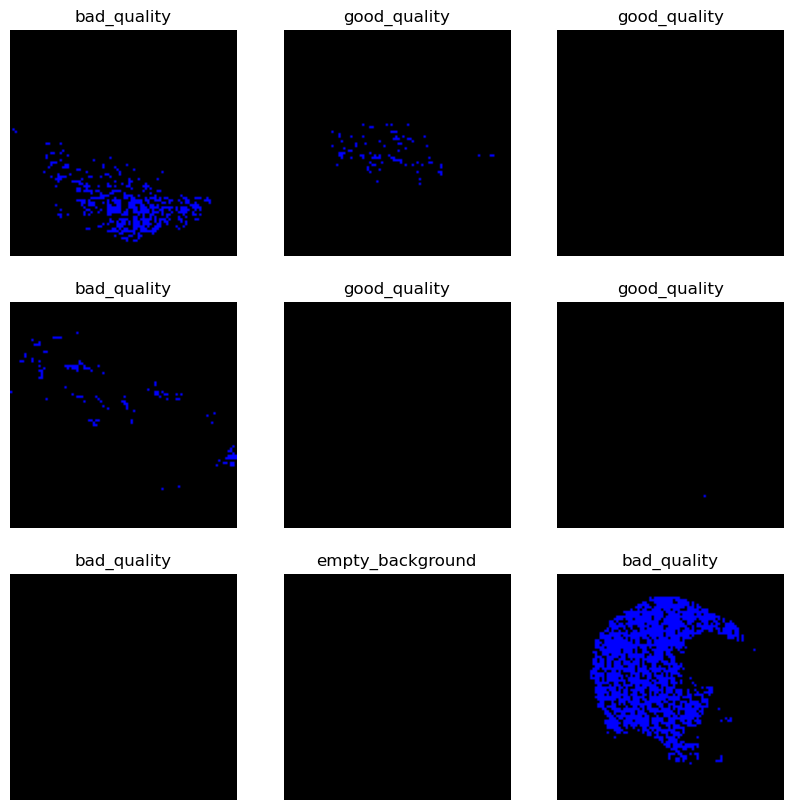

In [139]:
class_names = labels
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [140]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [141]:
test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [142]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch)
    break

(32, 96, 96, 3)
(32,)
tf.Tensor([0 2 1 0 0 2 0 0 2 0 2 0 0 1 0 1 2 0 0 0 2 1 0 2 1 0 1 0 2 2 0 0], shape=(32,), dtype=int32)


In [65]:
# classes = len(labels)
# print(f"The dataset contains {classes } classes.")

# Define the model

In [66]:
logdir = os.path.join("logs", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
root_logdir = os.getcwd()

In [67]:
#wandb.__version__

In [68]:
tf.keras.backend.clear_session()

# optimize the data flow
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().prefetch(AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [69]:
#api = wandb.Api()
api = wandb.Api(timeout=19)

In [70]:
# code taken from https://www.tensorflow.org/guide/keras/custom_callback#examples_of_keras_callback_applications

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [71]:
class EarlyStoppingAtMaxValAccuracy(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after max has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=30):
        super(EarlyStoppingAtMaxValAccuracy, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = 0
        self.best_epoch = 0
        self.best_epoch_loss = np.Infinity

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_accuracy")
        if np.greater(current, self.best):
            self.best = current
            self.best_epoch = epoch
            self.best_epoch_loss = logs.get("val_loss")
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

        metrics = dict()
        metrics["best_epoch"] = self.best_epoch
        metrics["best_val_accuracy"] = self.best
        metrics["best_epoch_loss"] = self.best_epoch_loss

        wandb.log(metrics)



    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
        


In [72]:
os.environ["WANDB_MODE"] = "online"
#os.environ["WANDB_MODE"] = "offline"
def train_model_wandb(model):

        # solve issue from: https://github.com/wandb/wandb/issues/3536
        if len(wandb.patched["tensorboard"]) > 0:
                wandb.tensorboard.unpatch()
                
        # Configure Tensorboard root log directory to read the debugging information
        wandb.tensorboard.patch(root_logdir=root_logdir)
        # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
        # Generate run ids
        id = wandb.util.generate_id()

        run = wandb.init(
                # Set the project where this run will be logged
                project=PROJECT, 
                id = id, 
                resume="allow",
                sync_tensorboard=True
                )

        # Specify the configuration variables
        config = wandb.config
        
        config.batch_size = BATCH_SIZE
        #config.dropout =DROPOUT
        config.learn_rate = LR
        config.momentum = MOMENTUM
        #config.decay = 1e-6
        config.epochs = EPOCHS
        config.classes = classes
        config.id = id
        config.architecture = model_name
        

        # enable Tensorflow Debugging
        #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
        #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

        optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM)
        config.optimizer = optimizer._name

        model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=10, update_freq="epoch") #, profile_batch="10, 20")
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir, histogram_freq=1)
        #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())

        def lr_schedule(epoch):
                """
                Returns a custom learning rate that decreases as epochs progress.
                """
                learning_rate = LR
                if epoch > 20:
                        learning_rate = 0.0001
                tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
                return learning_rate

        lr_callback = LearningRateScheduler(lr_schedule)

        best_model_path = Path(wandb.run.dir).joinpath(f"best_model")

        checkpoint = WandbModelCheckpoint(best_model_path,
                monitor="val_accuracy",
                save_best_only=True,
                save_freq="epoch")

        global early_stopping_patience
        early_stopping = EarlyStopping(monitor="val_accuracy", patience=early_stopping_patience)

        callbacks =[
                tensorboard_callback,
                lr_callback,
                #wandb_callback,
                WandbMetricsLogger(),
                checkpoint,
                #early_stopping,
                EarlyStoppingAtMaxValAccuracy()
        ]

        history = model.fit(train_ds,
                epochs=EPOCHS, 
                validation_data=val_ds, 
                callbacks=callbacks
        )

        #wandb.save("last_model.h5")




        #best_model = keras.models.load_model(best_model_path) # not needed due to "restore_best_weights=True"

        y_val_true = np.concatenate([y for x, y in val_ds], axis=0)
        y_val_pred = model.predict(val_ds).argmax(axis=1)

        y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
        y_test_pred = model.predict(test_ds).argmax(axis=1)

        results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
        print("test loss, test acc:", results)
        wandb.log({
                "test_loss" : results[0],
                "test_accuracy" : results[1]
        })

        # log data for the confusion matrix
        wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_test_true, preds=y_test_pred,
                        class_names=labels)})


        run.finish()
        return history, model, run.id

In [73]:
wandb.finish()
history, model, run_id = train_model_wandb(model)

Epoch 1/30
 5/64 [=>............................] - ETA: 1s - loss: 0.0290 - accuracy: 0.9937WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0785s). Check your callbacks.


63/64 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9841INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 29s 412ms/step - loss: 0.0558 - accuracy: 0.9832 - val_loss: 0.0893 - val_accuracy: 0.9643 - lr: 0.0100
Epoch 2/30
62/64 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9748

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 38ms/step - loss: 0.0848 - accuracy: 0.9743 - val_loss: 0.1892 - val_accuracy: 0.9246 - lr: 0.0100
Epoch 3/30
63/64 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9792INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 13s 198ms/step - loss: 0.0626 - accuracy: 0.9792 - val_loss: 0.0448 - val_accuracy: 0.9841 - lr: 0.0100
Epoch 4/30
62/64 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9859

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 42ms/step - loss: 0.0516 - accuracy: 0.9847 - val_loss: 0.2647 - val_accuracy: 0.9008 - lr: 0.0100
Epoch 5/30
64/64 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9253

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 43ms/step - loss: 0.1984 - accuracy: 0.9253 - val_loss: 0.2402 - val_accuracy: 0.9206 - lr: 0.0100
Epoch 6/30
64/64 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9644

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 47ms/step - loss: 0.0950 - accuracy: 0.9644 - val_loss: 0.4850 - val_accuracy: 0.8294 - lr: 0.0100
Epoch 7/30
64/64 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9733

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 53ms/step - loss: 0.0754 - accuracy: 0.9733 - val_loss: 0.1825 - val_accuracy: 0.9365 - lr: 0.0100
Epoch 8/30
62/64 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9783

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 48ms/step - loss: 0.0589 - accuracy: 0.9782 - val_loss: 0.1890 - val_accuracy: 0.9484 - lr: 0.0100
Epoch 9/30
62/64 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9849

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 4s 60ms/step - loss: 0.0479 - accuracy: 0.9852 - val_loss: 0.4552 - val_accuracy: 0.8929 - lr: 0.0100
Epoch 10/30
63/64 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9841

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 42ms/step - loss: 0.0504 - accuracy: 0.9837 - val_loss: 0.4481 - val_accuracy: 0.8730 - lr: 0.0100
Epoch 11/30
64/64 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9772

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 5s 74ms/step - loss: 0.0599 - accuracy: 0.9772 - val_loss: 0.1453 - val_accuracy: 0.9444 - lr: 0.0100
Epoch 12/30
64/64 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9857

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 2s 36ms/step - loss: 0.0476 - accuracy: 0.9857 - val_loss: 0.1010 - val_accuracy: 0.9762 - lr: 0.0100
Epoch 13/30
63/64 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9777

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 39ms/step - loss: 0.0664 - accuracy: 0.9772 - val_loss: 0.1097 - val_accuracy: 0.9484 - lr: 0.0100
Epoch 14/30
63/64 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9826

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 43ms/step - loss: 0.0505 - accuracy: 0.9827 - val_loss: 0.2577 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 15/30
62/64 [============================>.] - ETA: 0s - loss: 0.0447 - accuracy: 0.9844

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 4s 58ms/step - loss: 0.0441 - accuracy: 0.9847 - val_loss: 0.1354 - val_accuracy: 0.9405 - lr: 0.0100
Epoch 16/30
63/64 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9866

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 39ms/step - loss: 0.0338 - accuracy: 0.9861 - val_loss: 0.1525 - val_accuracy: 0.9524 - lr: 0.0100
Epoch 17/30
64/64 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9733

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 50ms/step - loss: 0.0679 - accuracy: 0.9733 - val_loss: 0.0966 - val_accuracy: 0.9524 - lr: 0.0100
Epoch 18/30
64/64 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9649

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 44ms/step - loss: 0.1051 - accuracy: 0.9649 - val_loss: 0.2926 - val_accuracy: 0.9127 - lr: 0.0100
Epoch 19/30
64/64 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9683

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 40ms/step - loss: 0.0766 - accuracy: 0.9683 - val_loss: 0.1967 - val_accuracy: 0.9286 - lr: 0.0100
Epoch 20/30
64/64 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9728

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 46ms/step - loss: 0.0727 - accuracy: 0.9728 - val_loss: 1.2589 - val_accuracy: 0.7262 - lr: 0.0100
Epoch 21/30
64/64 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9743

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 4s 58ms/step - loss: 0.0688 - accuracy: 0.9743 - val_loss: 0.1413 - val_accuracy: 0.9484 - lr: 0.0100
Epoch 22/30
63/64 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9757

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 45ms/step - loss: 0.0686 - accuracy: 0.9758 - val_loss: 0.1108 - val_accuracy: 0.9603 - lr: 1.0000e-04
Epoch 23/30
63/64 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.9777

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 41ms/step - loss: 0.0604 - accuracy: 0.9777 - val_loss: 0.0793 - val_accuracy: 0.9683 - lr: 1.0000e-04
Epoch 24/30
63/64 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9826

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 41ms/step - loss: 0.0483 - accuracy: 0.9827 - val_loss: 0.0848 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 25/30
63/64 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.9797

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 40ms/step - loss: 0.0619 - accuracy: 0.9787 - val_loss: 0.0866 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 26/30
62/64 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9773

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 48ms/step - loss: 0.0596 - accuracy: 0.9777 - val_loss: 0.0847 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 27/30
64/64 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9822

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 38ms/step - loss: 0.0491 - accuracy: 0.9822 - val_loss: 0.0837 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 28/30
63/64 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9767

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 40ms/step - loss: 0.0675 - accuracy: 0.9762 - val_loss: 0.0827 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 29/30
63/64 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9797

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


64/64 [==============================] - 3s 45ms/step - loss: 0.0507 - accuracy: 0.9797 - val_loss: 0.0791 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 30/30
63/64 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.9836

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230115_094640-3icpkc95\files\best_model)... Done. 0.0s


8/8 [==============================] - 0s 17ms/step - loss: 0.0897 - accuracy: 0.9686
test loss, test acc: [0.08967261761426926, 0.9686274528503418]


accuracy,█▇▇█▁▅▇▇██▇█▇███▇▆▆▆▇▇▇█▇▇█▇▇█
best_epoch,▁▁████████████████████████████
best_epoch_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_accuracy,▁▁████████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▂▃▂▂█▄▃▂▂▂▂▂▂▂▁▁▂▄▃▃▂▂▂▂▂▂▂▂▂▂
lr,█████████████████████▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▇▆█▆▆▄▇▇▆▅▇█▇▆▇▇▇▆▆▁▇▇████████
val_loss,▁▂▁▂▂▄▂▂▃▃▂▁▁▂▂▂▁▂▂█▂▁▁▁▁▁▁▁▁▁


In [32]:
#!wandb sync i:\tinyml\tiny_cnn\wandb\offline-run-20221227_091238-1vzrst0a

# Conversion to TFLITE

In [149]:



sample_iter = test_ds.as_numpy_iterator()

for i in range(1):
    sample = next(sample_iter)[0]
print("Number of samples: {}".format(sample.shape[0]))

Number of samples: 1


In [80]:
def representative_data_gen():
    for i in range(100):
      yield([test_ds[i].reshape(1, 1)])

In [83]:
representative_data_gen()

<generator object representative_data_gen at 0x000001F890D66DC0>

In [97]:
repr_ds = test_ds.unbatch()

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(48):
    yield [i_value]


# def representative_data_gen():
#     for i in range(100):
#       yield([test_ds[i].reshape(1, 1)])

# def representative_data_gen():
#   for data in test_ds.batch(1).take(100):
#     yield [tf.dtypes.cast(data, tf.float32)]

# def representative_data_gen():
#     for i in range(BATCH_SIZE):
#         yield([np.expand_dims(sample[i], axis=0)])

# testing dataset
# def representative_data_gen():
#     for _ in range(100):
#       data = np.random.rand(1, 96, 96, 3)
#       yield [data.astype(np.float32)]
 
    
converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)


# set the optimization flag
converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
# enforce integer only quantization
converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_opt.inference_input_type = tf.uint8
converter_opt.inference_output_type = tf.uint8

# provide a representative dataset for quantization
#converter_opt.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter_opt.representative_dataset = representative_data_gen

tflite_model_opt = converter_opt.convert()

# Save the model.
with open(models_tflite_opt_path, 'wb') as f:
  f.write(tflite_model_opt)


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpt1oq3l23\assets


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpt1oq3l23\assets
d:\Miniconda\envs\tiny_cnn_3\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


# Run the TensorFlot Lite models


In [150]:
test_image = test_ds.take(1)
test_image

<TakeDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [134]:
len(test_ds)

8

In [151]:
#test_gen = test_ds.unbatch().batch(1)
test_gen = test_ds.as_numpy_iterator()
#test_gen = test_gen.next() 
#test_image = test_gen.take(1)
test_image = next(test_gen)[0]
test_image


array([[[[-0.33998156, -0.33213842, -0.35174626],
         [-0.35225183, -0.3444087 , -0.36401653],
         [-0.36940867, -0.36156553, -0.38117337],
         ...,
         [-0.3047487 , -0.30222118, -0.33359373],
         [-0.2494638 , -0.24554223, -0.27691478],
         [-0.3516084 , -0.34768683, -0.37905937]],

        [[-0.42683822, -0.42683822, -0.43468136],
         [-0.3713541 , -0.3713541 , -0.37919724],
         [-0.36905634, -0.36513478, -0.38474262],
         ...,
         [-0.30284923, -0.30284923, -0.34206492],
         [-0.29128367, -0.28344053, -0.32657778],
         [-0.29404104, -0.2861979 , -0.32933515]],

        [[-0.51554835, -0.51554835, -0.5233915 ],
         [-0.41674322, -0.41674322, -0.42458636],
         [-0.3831188 , -0.3831188 , -0.39096195],
         ...,
         [-0.3132046 , -0.3132046 , -0.35242033],
         [-0.309375  , -0.3039828 , -0.34589458],
         [-0.22161454, -0.21859676, -0.2530024 ]],

        ...,

        [[-0.7803155 , -0.7920803 , -0

In [154]:
len(list(test_gen))

254

In [152]:
test_image.shape

(1, 96, 96, 3)

In [161]:
def tflite_predict(model_path, test_image):
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(model_path))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:  # was np.uint8
        input_scale, input_zero_point = input_details["quantization"]
        test_image = test_image / input_scale + input_zero_point
        
    test_image = test_image.astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    #interpreter.set_tensor(input_details["index"], np.expand_dims(test_image[0], axis=0)) # only needed when input shape (96, 96, 3)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    prediction = output.argmax()
    print(f"Prediction: Class {prediction} derived from {output}")

    return prediction

In [163]:
tflite_result = tflite_predict(models_tflite_opt_path, test_image)

Prediction: 2 derived from [  5   0 251]


255

In [189]:

def tflite_predict_on_dataset(model_path, dataset):
    # find length of dataset
    test_gen = dataset.as_numpy_iterator()
    num_images = len(list(test_gen))

    predictions = []
    y_trues = []

    test_gen = dataset.as_numpy_iterator()
    # iterate over the complete test_set
    for i in range(num_images):
        test_image, y_true = next(test_gen)
        prediction = tflite_predict(model_path, test_image)
        predictions.append(prediction)
        y_trues.append(y_true[0])
        print(f"{i}, {test_image.shape} - true label: {y_true[0]} vs {tflite_result}")

    accuracy = (np.sum(predictions == y_trues) * 100) / num_images
    print(f"Accuracy: {accuracy} - (Number of test samples: {num_images})")
    return predictions, y_trues
    

In [190]:
preds, trues = tflite_predict_on_dataset(models_tflite_opt_path, test_ds)

Prediction: 0 derived from [255   0   1]
0, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [255   0   1]
1, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [255   0   0]
2, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [255   0   0]
3, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [252   1   3]
4, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [249   0   7]
5, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [255   0   0]
6, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [253   0   3]
7, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [241   0  15]
8, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [255   0   0]
9, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [235   0  20]
10, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [255   0   0]
11, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: 0 derived from [251   0   

In [188]:
preds

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,


In [ ]:
accuracy = (np.sum(preds == trues) * 100) / len(test_images)

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [96]:
input_details

{'name': 'serving_default_input_1:0',
 'index': 0,
 'shape': array([ 1, 96, 96,  3]),
 'shape_signature': array([-1, 96, 96,  3]),
 'dtype': numpy.int8,
 'quantization': (0.003921568859368563, 127),
 'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
  'zero_points': array([127]),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [89]:
# code copied from: https://www.tensorflow.org/lite/performance/post_training_integer_quant

# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


In [ ]:

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

# Model evaluation

In [35]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test[:3])
# print("predictions shape:", predictions.shape)

Evaluate on test data
8/8 [==============================] - 0s 15ms/step - loss: 0.1044 - accuracy: 0.9490
test loss, test acc: [0.10444378107786179, 0.9490196108818054]


In [36]:
# entity = "susbrock"


# run = api.run(f"{entity}/{PROJECT}/{run_id}")
# run.summary["test_accuracy"] = results[1]
# run.summary["test_loss"] = results[0]
# run.summary.update()

In [37]:
results

[0.10444378107786179, 0.9490196108818054]

In [38]:
scores = model.evaluate(test_ds, verbose=0)

In [39]:
scores

[0.10444378107786179, 0.9490196108818054]

In [40]:
model.metrics_names

['loss', 'accuracy']

In [41]:
test_predictions = model.predict(test_ds)
test_predictions

8/8 [==============================] - 0s 14ms/step


array([[9.94245350e-01, 1.25133738e-04, 5.62951015e-03],
       [9.98880327e-01, 1.68906681e-05, 1.10280362e-03],
       [9.97094631e-01, 1.94407854e-04, 2.71096290e-03],
       [9.96474087e-01, 5.77780665e-05, 3.46820033e-03],
       [9.41265285e-01, 3.47004714e-03, 5.52647412e-02],
       [9.89815831e-01, 2.57140520e-04, 9.92704183e-03],
       [9.96301413e-01, 3.91764152e-05, 3.65940249e-03],
       [4.99306262e-01, 5.42357098e-03, 4.95270193e-01],
       [9.87599134e-01, 7.28574290e-04, 1.16723338e-02],
       [9.99050558e-01, 3.10949908e-05, 9.18365025e-04],
       [4.43278879e-01, 2.18170416e-03, 5.54539382e-01],
       [9.88421202e-01, 3.48973786e-04, 1.12298680e-02],
       [9.89429295e-01, 4.42296965e-04, 1.01284068e-02],
       [9.99645829e-01, 5.85391263e-06, 3.48375994e-04],
       [9.84614670e-01, 7.49058905e-04, 1.46362195e-02],
       [9.66559350e-01, 7.74628716e-04, 3.26660536e-02],
       [9.92947340e-01, 4.17776580e-04, 6.63494365e-03],
       [8.96689057e-01, 3.41575

In [42]:
top_pred_ids = test_predictions.argmax(axis=1)
len(top_pred_ids)

255

In [43]:
top_pred_ids

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0], dtype=int64)

In [44]:
y_true = [y for x, y in test_ds]
y_true

[<tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2])>,
 <tf.Tensor: shape=(32,), dtype=in

In [45]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
len(y_true)

255

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true, top_pred_ids, num_classes=classes)
    # list(ds_test.map(lambda x, y: y)),
    # predict_class_label_number(test_data),
    # num_classes=len(label_names))
    
confusion_mtx

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 91,   1,   4],
       [  0,  46,   0],
       [  8,   0, 105]])>

In [47]:
# sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
#               annot=True, fmt='g')

In [48]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

In [49]:
#show_confusion_matrix(confusion_mtx, labels)

In [50]:
top_pred_ids

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0], dtype=int64)

In [51]:
#val_predictions

## Code reserved for troubleshooting

In [52]:
def mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha):
    model = tf.keras.applications.mobilenet.MobileNet(
        input_shape=input_shape,
        alpha=alpha,
        depth_multiplier=1,
        dropout=0.001,
        include_top=True,
        weights=None, #'imagenet'
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model
    #model = mobilenet_v1_keras((IMG_WIDTH, IMG_HEIGHT, 3), classes=classes, alpha=alpha)

In [53]:
#os.environ["WANDB_MODE"] = "online"
def train_model(model):

        # solve issue from: https://github.com/wandb/wandb/issues/3536
        # if len(wandb.patched["tensorboard"]) > 0:
        #         wandb.tensorboard.unpatch()
                
        # Configure Tensorboard root log directory to read the debugging information
        #wandb.tensorboard.patch(root_logdir=root_logdir)
        # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
        # wandb.init(
        #         # Set the project where this run will be logged
        #         project=PROJECT, 
        #         # Track hyperparameters and run metadata
        #         #config={
        #         #"learning_rate": LR,
        #         #"epochs": EPOCHS,
        #         #},
        #         sync_tensorboard=True
        #         )



        # config = wandb.config
        # # Specify the configuration variables
        # config.batch_size = BATCH_SIZE
        # config.dropout =DROPOUT
        # config.learn_rate = LR
        # #config.decay = 1e-6
        # #config.momentum = 0.9
        # config.epochs = EPOCHS
        # config.classes = classes
        

        # enable Tensorflow Debugging
        #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
        #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

        #model = mobilenet
        model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=10, update_freq="epoch") #, profile_batch="10, 20")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir) #, histogram_freq=1)
        #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())

        early_stopping = EarlyStopping(monitor="val_accuracy", patience=50)

        #checkpoint = ModelCheckpoint("my_tiny_model", save_weights_only=True)

        callbacks =[
                #tensorboard_callback,
                #wandb_callback,
                #WandbMetricsLogger(),
                #checkpoint,
                #early_stopping
        ]

        history = model.fit(train_ds,
                epochs=EPOCHS, 
                validation_data=val_ds, 
                callbacks=callbacks
        )

        # wandb.log({
        #         "loss": history.history["loss"],
        #         "accuracy": history.history["accuracy"],
        #         "val_loss": history.history["val_loss"],
        #         "val_accuracy": history.history["val_accuracy"],                                
        # })
        
        #wandb.finish()
        return history, model


In [54]:
# model.compile(optimizer='adam',
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])